In [1]:
import numpy
import pandas 
import geopandas as gpd
import pysal
import seaborn
import contextily
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

In [2]:
traffic_data = gpd.read_file('wellington_crash.geojson')

In [3]:
traffic_data .info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 12291 entries, 0 to 12290
Data columns (total 71 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   OBJECTID                   12291 non-null  int32   
 1   advisorySpeed              151 non-null    float64 
 2   areaUnitID                 12291 non-null  int32   
 3   bicycle                    12291 non-null  float64 
 4   bridge                     4979 non-null   float64 
 5   bus                        12291 non-null  float64 
 6   carStationWagon            12291 non-null  float64 
 7   cliffBank                  4979 non-null   float64 
 8   crashDirectionDescription  12291 non-null  object  
 9   crashFinancialYear         12291 non-null  object  
 10  crashLocation1             12291 non-null  object  
 11  crashLocation2             12254 non-null  object  
 12  crashRoadSideRoad          0 non-null      object  
 13  crashSeverity          

In [4]:
traffic_data.head()

,OBJECTID,advisorySpeed,areaUnitID,bicycle,bridge,bus,carStationWagon,cliffBank,crashDirectionDescription,crashFinancialYear,...,tree,truck,unknownVehicleType,urban,vanOrUtility,vehicle,waterRiver,weatherA,weatherB,geometry
0,66388986,NaN,575300,0.0,0.0,0.0,1.0,1.0,South,2018/2019,...,0.0,0.0,0.0,Urban,0.0,0.0,0.0,Light rain,Null,POINT (174.7576 -41.28854)
1,66388998,NaN,572600,0.0,0.0,0.0,2.0,0.0,North,2017/2018,...,0.0,0.0,0.0,Urban,0.0,0.0,0.0,Fine,Null,POINT (174.82511 -41.16802)
2,66389034,NaN,577000,0.0,NaN,0.0,1.0,NaN,South,2019/2020,...,NaN,0.0,0.0,Urban,0.0,NaN,NaN,Fine,Null,POINT (174.81144 -41.3266)
3,66389036,NaN,576800,0.0,NaN,0.0,0.0,NaN,East,2018/2019,...,NaN,0.0,0.0,Urban,1.0,NaN,NaN,Light rain,Null,POINT (174.79145 -41.30418)
4,66389128,NaN,572900,0.0,NaN,0.0,2.0,NaN,Null,2017/2018,...,NaN,0.0,0.0,Urban,0.0,NaN,NaN,Fine,Null,POINT (174.77253 -41.27599)


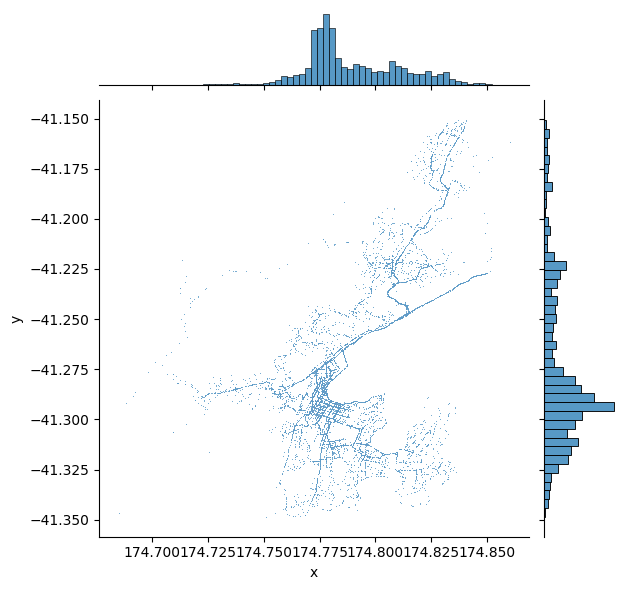

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Extract the x and y coordinates from the geometry column
traffic_data['x'] = traffic_data['geometry'].apply(lambda x: x.x)
traffic_data['y'] = traffic_data['geometry'].apply(lambda x: x.y)

# Generate the scatter plot
sns.jointplot(x="x", y="y", data=traffic_data, s=0.5);
plt.show()

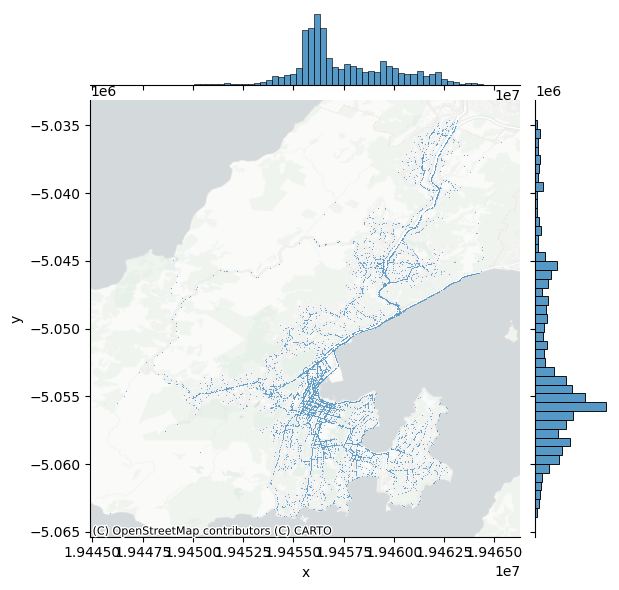

In [6]:

# Ensure the traffic data is in EPSG:3857
traffic_data = traffic_data.to_crs(epsg=3857)

# Extract the x and y coordinates from the geometry column
traffic_data['x'] = traffic_data['geometry'].apply(lambda geom: geom.x)
traffic_data['y'] = traffic_data['geometry'].apply(lambda geom: geom.y)

# Generate the scatter plot
joint_axes = sns.jointplot(x="x", y="y", data=traffic_data, s=0.5)

# Add the basemap
contextily.add_basemap(
    joint_axes.ax_joint,
    crs=traffic_data.crs.to_string(),  # Use the traffic data's CRS
    source=contextily.providers.CartoDB.PositronNoLabels
)

plt.show()


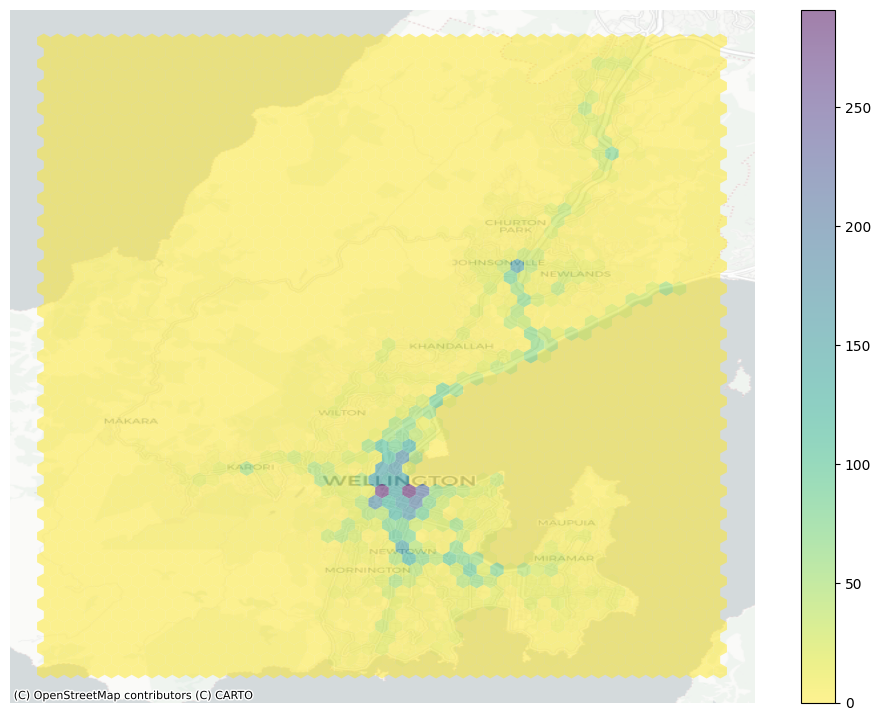

In [7]:
import contextily as ctx
import matplotlib.pyplot as plt

# Ensure the traffic data is in EPSG:3857 (Web Mercator) for compatibility with the basemap
traffic_data = traffic_data.to_crs(epsg=3857)

# Extract the x and y coordinates from the geometry column
traffic_data['x'] = traffic_data['geometry'].apply(lambda x: x.x)
traffic_data['y'] = traffic_data['geometry'].apply(lambda x: x.y)

# Set up figure and axis
f, ax = plt.subplots(1, figsize=(12, 9))

# Generate and add hexbin with 50 hexagons in each dimension, no borderlines, half transparency, and reverse viridis colormap
hb = ax.hexbin(
    traffic_data["x"],
    traffic_data["y"],
    gridsize=50,
    linewidths=0,
    alpha=0.5,
    cmap="viridis_r"
)

# Add basemap
ctx.add_basemap(
    ax, 
    source=ctx.providers.CartoDB.Positron,
    crs=traffic_data.crs.to_string()  # Use traffic_data CRS (should now be EPSG:3857)
)

# Add colorbar
plt.colorbar(hb)

# Remove axes
ax.set_axis_off()

plt.show()


/tmp/ipykernel_4085958/4146003283.py:23: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


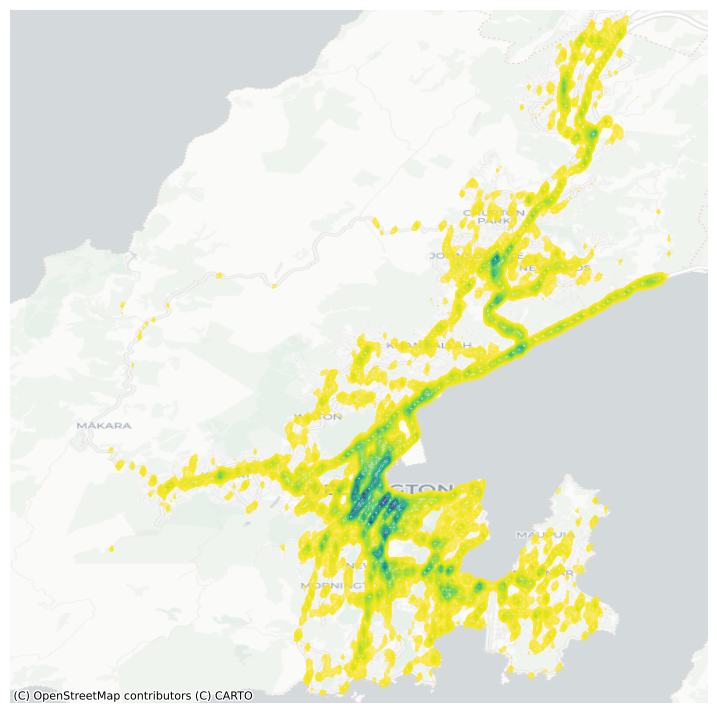

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
import pandas as pd

# Ensure traffic_data is a GeoDataFrame with geometry column
traffic_data = gpd.GeoDataFrame(traffic_data, geometry='geometry')

# Reproject to EPSG:3857 (Web Mercator) for compatibility with the basemap
traffic_data = traffic_data.to_crs(epsg=3857)

# Create a new DataFrame with the x and y coordinates
coords_df = pd.DataFrame({
    'x': traffic_data.geometry.x,
    'y': traffic_data.geometry.y
})

# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))

# Generate and add KDE with adjusted bandwidth
sns.kdeplot(
    data=coords_df,
    x='x',
    y='y',
    shade=True,
    n_levels=50,
    alpha=0.55,
    cmap="viridis_r",
    ax=ax,
    bw_adjust=0.1  # Adjust the bandwidth (0.5 will make it more sensitive)
)

# Add basemap
ctx.add_basemap(
    ax, 
    source=ctx.providers.CartoDB.Positron,
    crs=traffic_data.crs.to_string()  # Use traffic_data CRS (EPSG:3857)
)

# Remove axes
ax.set_axis_off()

plt.show()


In [9]:
import pandas as pd
from pointpats import centrography

# Assuming db is a DataFrame with 'x' and 'y' columns extracted from your traffic data
# For example, if you're using traffic_data's geometry
db = pd.DataFrame({
    'x': traffic_data.geometry.x,
    'y': traffic_data.geometry.y
})

# Calculate the mean center
mean_center = centrography.mean_center(db[["x", "y"]])

# Calculate the Euclidean median (geometric median)
med_center = centrography.euclidean_median(db[["x", "y"]])

# Display the results
print(f"Mean Center: {mean_center}")
print(f"Euclidean Median: {med_center}")


Mean Center: [19457451.13623447 -5053174.82743835]
Euclidean Median: [19456413.48276475 -5055053.71627146]


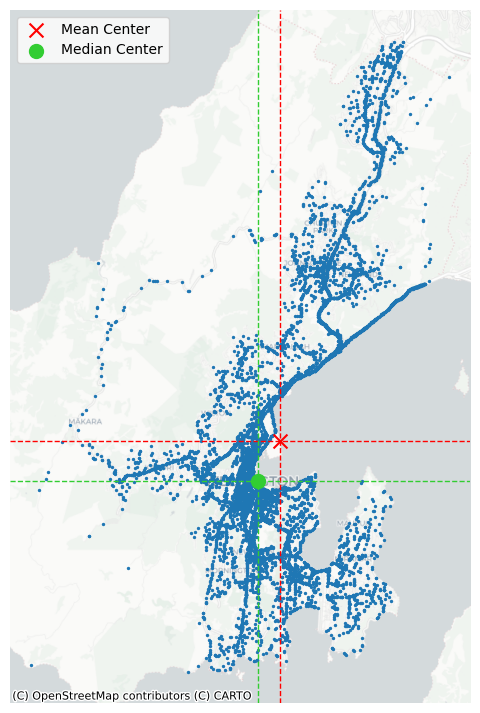

In [10]:
import contextily as ctx
import matplotlib.pyplot as plt

# Assuming traffic_data is already defined and contains geometry
# Reproject traffic data to Web Mercator (EPSG:3857)
traffic_data = traffic_data.to_crs(epsg=3857)

# Calculate mean and median centers (assuming db is defined as before)
mean_center = centrography.mean_center(db[["x", "y"]])
med_center = centrography.euclidean_median(db[["x", "y"]])

# Create a new figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))

# Plot the traffic data (assuming it's already projected to Web Mercator)
traffic_data.plot(ax=ax, markersize=2)

# Add the basemap, focused on Wellington
ctx.add_basemap(
    ax, 
    source=ctx.providers.CartoDB.Positron,
    zoom=12  # Adjust zoom level for the desired detail
)

# Add mean center point and marginal lines
ax.scatter(*mean_center, color="red", marker="x", s=100, label="Mean Center")
ax.axvline(mean_center[0], color="red", linestyle='--', linewidth=1)
ax.axhline(mean_center[1], color="red", linestyle='--', linewidth=1)

# Add median center point and marginal lines
ax.scatter(*med_center, color="limegreen", marker="o", s=100, label="Median Center")
ax.axvline(med_center[0], color="limegreen", linestyle='--', linewidth=1)
ax.axhline(med_center[1], color="limegreen", linestyle='--', linewidth=1)

# Legend
ax.legend()

# Clean axes
ax.set_axis_off()

# Display the plot
plt.show()

In [11]:
import numpy as np
from pointpats import centrography

# Extract the x and y coordinates from the geometry column
coords = traffic_data.geometry.apply(lambda geom: (geom.x, geom.y)).tolist()
coords_array = np.array(coords)

# Calculate the standard distance using centrography
std_distance = centrography.std_distance(coords_array)

# Print the result
print("Standard Distance:", std_distance)


Standard Distance: 6508.961977415254


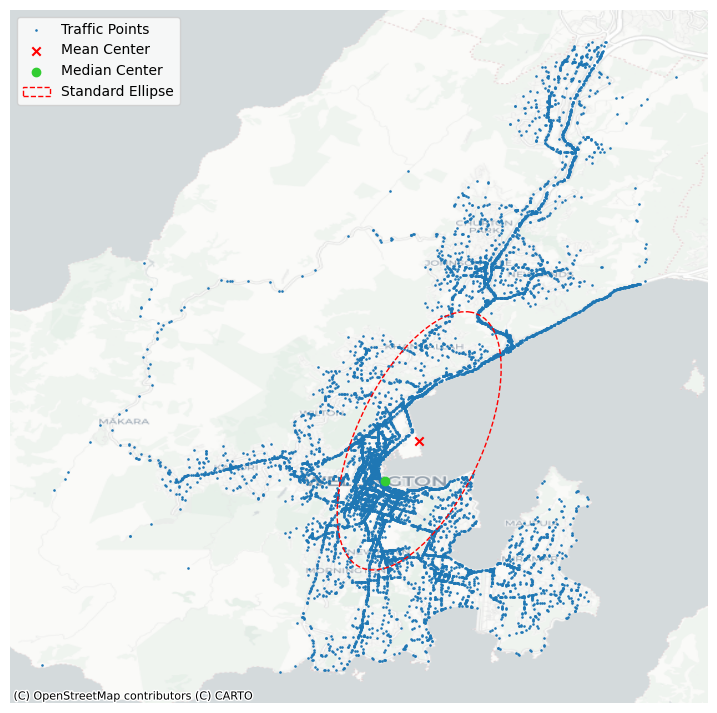

In [12]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from pointpats import centrography
from matplotlib.patches import Ellipse

# Ensure your traffic_data GeoDataFrame has 'x' and 'y' coordinates
traffic_data['x'] = traffic_data['geometry'].apply(lambda geom: geom.x)
traffic_data['y'] = traffic_data['geometry'].apply(lambda geom: geom.y)

# Calculate mean and median centers
mean_center = centrography.mean_center(traffic_data[['x', 'y']].values)
med_center = centrography.euclidean_median(traffic_data[['x', 'y']].values)

# Calculate the covariance matrix
covariance_matrix = np.cov(traffic_data[['x', 'y']].T)

# Eigenvalues and eigenvectors of the covariance matrix
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

# Major and minor axes lengths are proportional to the square roots of the eigenvalues
major = 2 * np.sqrt(eigenvalues[0])  # Major axis length
minor = 2 * np.sqrt(eigenvalues[1])  # Minor axis length

# Angle of rotation in radians, converted to degrees
rotation = np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0])

# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))

# Plot traffic points
ax.scatter(traffic_data['x'], traffic_data['y'], s=0.75, label='Traffic Points')

# Plot mean and median centers
ax.scatter(*mean_center, color="red", marker="x", label="Mean Center")
ax.scatter(*med_center, color="limegreen", marker="o", label="Median Center")

# Construct the standard ellipse using Matplotlib
ellipse = Ellipse(
    xy=mean_center,  # center the ellipse on the mean center
    width=major,  # full width
    height=minor,  # full height
    angle=np.rad2deg(rotation),  # convert radians to degrees
    facecolor="none",
    edgecolor="red",
    linestyle="--",
    label="Standard Ellipse"
)
ax.add_patch(ellipse)

# Add legend
ax.legend()

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Clean up axes and display the plot
ax.set_axis_off()
plt.show()

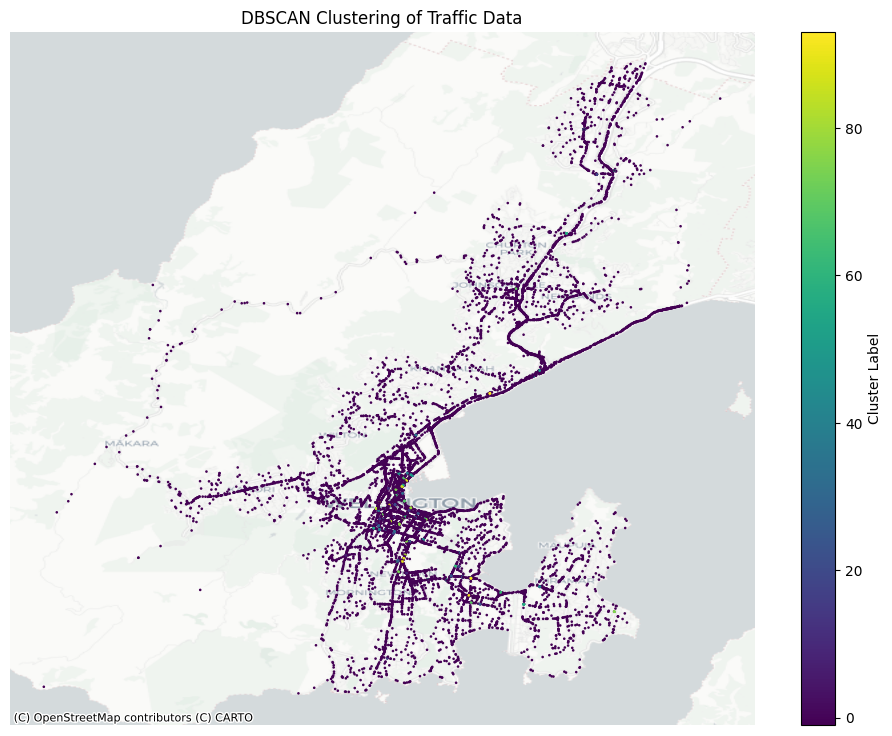

In [13]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from sklearn.cluster import DBSCAN

# Ensure your traffic_data GeoDataFrame has 'x' and 'y' coordinates
traffic_data['x'] = traffic_data['geometry'].apply(lambda geom: geom.x)
traffic_data['y'] = traffic_data['geometry'].apply(lambda geom: geom.y)

# Create a DataFrame for clustering
db = traffic_data[['x', 'y']].copy()

# Define DBSCAN parameters
epsilon = 0.01  # This defines the maximum distance between two samples for them to be considered as in the same neighborhood
min_samples = 5  # Minimum number of samples in a neighborhood for a point to be considered a core point

# Define DBSCAN
clusterer = DBSCAN(eps=epsilon, min_samples=min_samples)
# Fit to our data
cluster_labels = clusterer.fit_predict(db[['x', 'y']])

# Add cluster labels to the original DataFrame
traffic_data['cluster'] = cluster_labels

# Create a new figure and axis
f, ax = plt.subplots(1, figsize=(12, 9))

# Plot traffic data with clusters
scatter = ax.scatter(traffic_data['x'], traffic_data['y'], c=traffic_data['cluster'], cmap='viridis', s=0.75, label='Traffic Points')

# Add mean and median centers if needed
# ax.scatter(*mean_center, color="red", marker="x", label="Mean Center")
# ax.scatter(*med_center, color="limegreen", marker="o", label="Median Center")

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Clean up axes and display the plot
ax.set_axis_off()
plt.title("DBSCAN Clustering of Traffic Data")
plt.colorbar(scatter, label='Cluster Label')
plt.show()


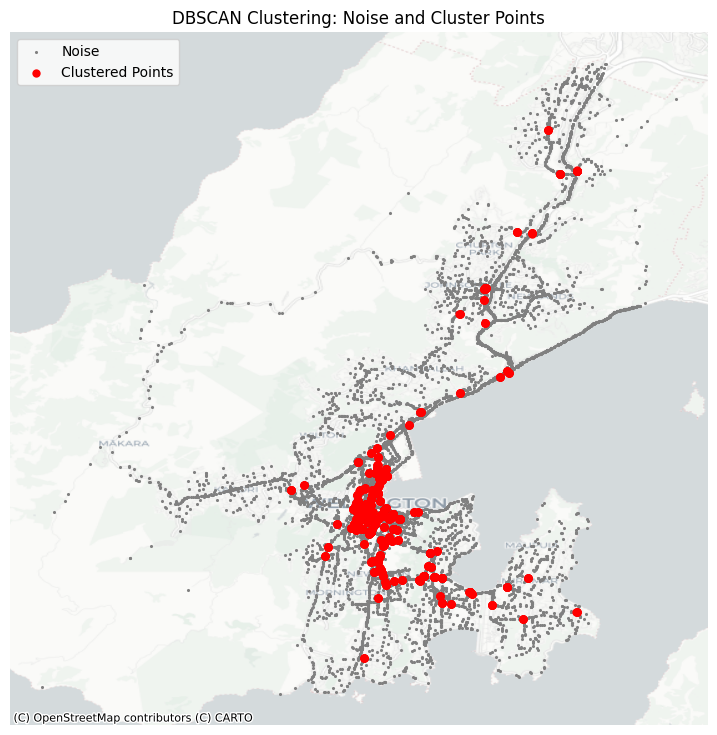

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx
from sklearn.cluster import DBSCAN

# Assuming `db` is your DataFrame containing 'x' and 'y' coordinates
# Define `minp` as the minimum number of samples for clustering
minp = 5  # You can adjust this value based on your data

# Rerun DBSCAN
clusterer = DBSCAN(eps=5, min_samples=minp)
clusterer.fit(db[["x", "y"]])

# Turn labels into a Series
lbls = pd.Series(clusterer.labels_, index=db.index)

# Setup figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))

# Subset points that are not part of any cluster (noise)
noise = db.loc[lbls == -1, ["x", "y"]]

# Plot noise in grey
ax.scatter(noise["x"], noise["y"], c="grey", s=5, linewidth=0, label="Noise")

# Plot all points that are not noise in red
clustered_points = db.loc[db.index.difference(noise.index), ["x", "y"]]
ax.scatter(
    clustered_points["x"],
    clustered_points["y"],
    c="red",
    linewidth=0,
    label="Clustered Points"
)

# Add basemap
ctx.add_basemap(
    ax, source=ctx.providers.CartoDB.Positron
)

# Remove axes
ax.set_axis_off()

# Add legend for clarity
ax.legend()

# Display the figure
plt.title("DBSCAN Clustering: Noise and Cluster Points")
plt.show()


In [15]:
import pandas as pd

# Extract x and y coordinates from the geometry column
traffic_data['x'] = traffic_data['geometry'].x
traffic_data['y'] = traffic_data['geometry'].y

# Create a DataFrame with coordinates
coordinates = traffic_data[['x', 'y']].values


In [16]:
from pointpats import random

# Generate a random pattern based on the number of observed points
random_pattern = random.poisson(coordinates, size=len(coordinates))


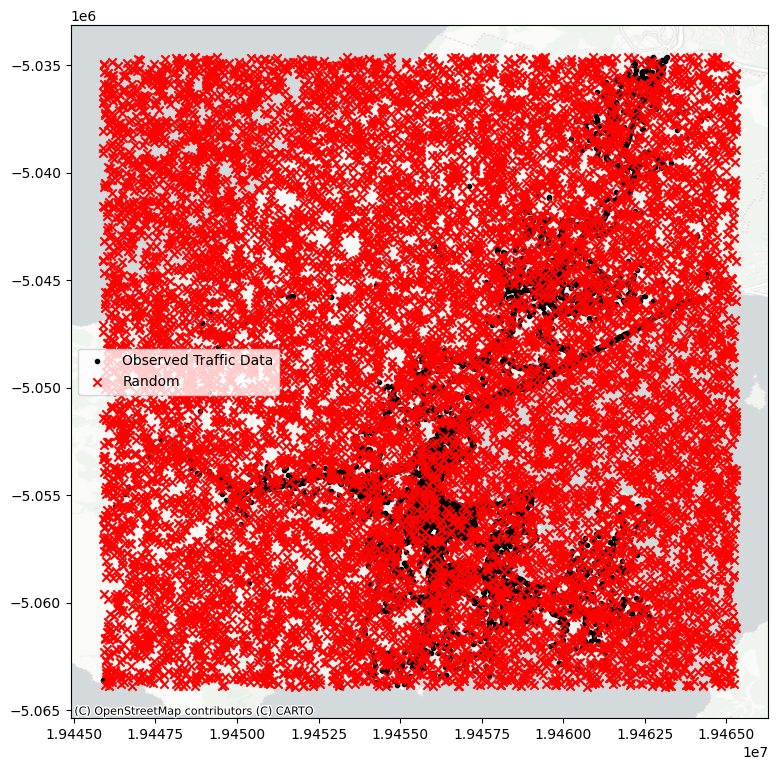

In [17]:
import matplotlib.pyplot as plt
import contextily as ctx

# Set up the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))

# Plot observed points
plt.scatter(coordinates[:, 0], coordinates[:, 1], color="k", marker=".", label="Observed Traffic Data")

# Plot random points
plt.scatter(random_pattern[:, 0], random_pattern[:, 1], color="r", marker="x", label="Random")

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Add legend
ax.legend(ncol=1, loc="center left")

# Show the plot
plt.show()


Observed counts in each quadrant:
    0    1    2    3     4     5    6    7    8    9    10   11  12   13   14  \
0    1    0    0    0     2     1    0    0    0    0    0    0   0    0    0   
1    0    0    0    0     0     2    3    0    0    0    0    0   0    0    0   
2    0    0    0    3     0    17    1    6    5    5    1    0   0    0    0   
3    0    0    1    0    50    15    0    0    4    2    0    0   0    0    0   
4    0    0    0    0     8    94    0    0    0    5    0    0   0    0    0   
5    0    0    0    0    20    70    0    0    0    3    0    0   0    0    0   
6   19   17   27   53   117   164   33    3    0    1    2    0   0    0    0   
7   66   15   63  194   650   211   40   69    5    0    0    1   0    0    0   
8   47  106  404  774  1681  1009  270   73   45    0    4    5   1    0    0   
9   40   73  331  229   323    19  211  174   70    6    5    9   1    0    0   
10   0   54  384  108   138     1    0  128   48   95  120   31   9    0   

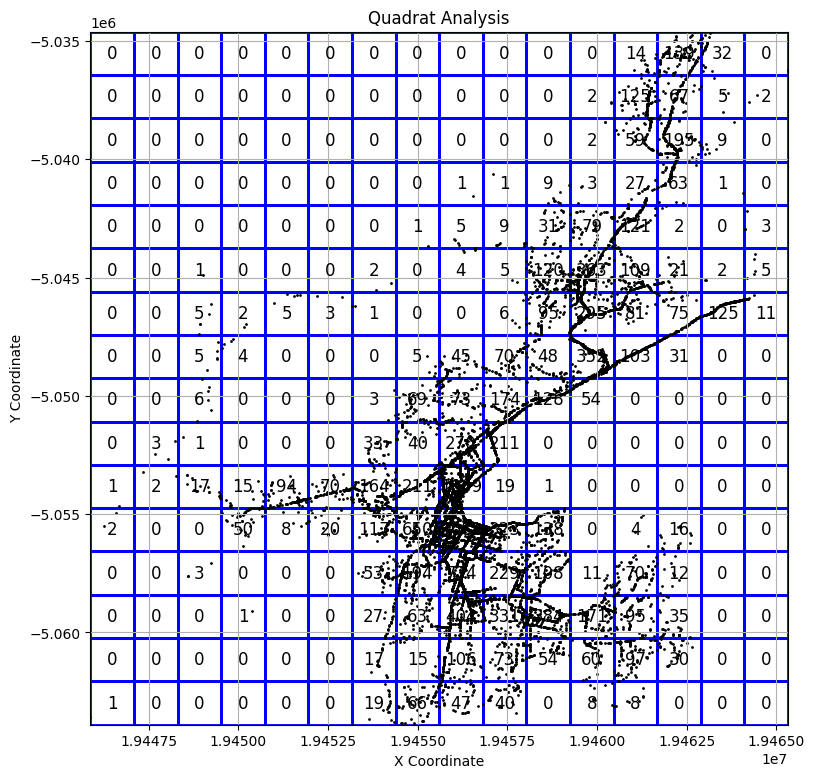

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming `traffic_data` has already been defined and contains 'x' and 'y' coordinates.
# Create a DataFrame from the geometry column if needed
traffic_data['x'] = traffic_data['geometry'].apply(lambda geom: geom.x)
traffic_data['y'] = traffic_data['geometry'].apply(lambda geom: geom.y)

# Define the number of quadrants (for example, 4x4 grid)
n_quadrants = 16

# Determine the bounds of the area
x_min, x_max = traffic_data['x'].min(), traffic_data['x'].max()
y_min, y_max = traffic_data['y'].min(), traffic_data['y'].max()

# Create the grid
x_bins = np.linspace(x_min, x_max, n_quadrants + 1)
y_bins = np.linspace(y_min, y_max, n_quadrants + 1)

# Create a DataFrame to hold counts
quadrat_counts = pd.DataFrame(0, index=range(n_quadrants), columns=range(n_quadrants))

# Count the points in each quadrant
for i in range(n_quadrants):
    for j in range(n_quadrants):
        count = traffic_data[
            (traffic_data['x'] >= x_bins[i]) & (traffic_data['x'] < x_bins[i + 1]) &
            (traffic_data['y'] >= y_bins[j]) & (traffic_data['y'] < y_bins[j + 1])
        ].shape[0]
        quadrat_counts.iat[i, j] = count

# Print the counts
print("Observed counts in each quadrant:")
print(quadrat_counts)

# Calculate expected counts (assuming uniform distribution)
expected_count = traffic_data.shape[0] / (n_quadrants ** 2)
print(f"Expected count per quadrant: {expected_count}")

# Visualize the quadrat counts
f, ax = plt.subplots(figsize=(9, 9))
for i in range(n_quadrants):
    for j in range(n_quadrants):
        rect = plt.Rectangle((x_bins[i], y_bins[j]), x_bins[i + 1] - x_bins[i], y_bins[j + 1] - y_bins[j],
                             fill=False, edgecolor='blue', lw=2)
        ax.add_patch(rect)
        ax.text((x_bins[i] + x_bins[i + 1]) / 2, (y_bins[j] + y_bins[j + 1]) / 2,
                 f"{int(quadrat_counts.iat[i, j])}", ha='center', va='center', fontsize=12)

# Plot the points
ax.scatter(traffic_data['x'], traffic_data['y'], color='k', s=1)
ax.set_title("Quadrat Analysis")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.grid(True)
plt.show()
